In [1]:
# Load libraries
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.preprocessing import MinMaxScaler
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler


from sklearn.model_selection import StratifiedShuffleSplit

%matplotlib inline

In [2]:
# Reading data into pandas dataframe

df = pd.read_csv('/data/Lana/credit_card_transactions-ibm_v2.csv')
#Removing strange characters from columns
df.columns = df.columns.str.replace(' ', '')
df.columns = df.columns.str.replace('\?', '')
# Removing special characters from dataset
df['Amount'] = df['Amount'].str.replace('\$', '')
df['UseChip'] = df['UseChip'].str.replace(' ', '')

# Converting MerchantName column to string
df['MerchantName'] = df['MerchantName'].apply(str)

# Replacing Yes/No by 1s and 0s
df['IsFraud'] = df.IsFraud.map(dict(Yes=1, No=0))

df.head()

<ipython-input-2-168d1edc500a>:6: FutureWarning: The default value of regex will change from True to False in a future version.
  df.columns = df.columns.str.replace('\?', '')
<ipython-input-2-168d1edc500a>:8: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Amount'] = df['Amount'].str.replace('\$', '')


User  Card  Year  Month  Day   Time  Amount           UseChip  \
0     0     0  2002      9    1  06:21  134.09  SwipeTransaction   
1     0     0  2002      9    1  06:42   38.48  SwipeTransaction   
2     0     0  2002      9    2  06:22  120.34  SwipeTransaction   
3     0     0  2002      9    2  17:45  128.95  SwipeTransaction   
4     0     0  2002      9    3  06:23  104.71  SwipeTransaction   

          MerchantName   MerchantCity MerchantState      Zip   MCC Errors  \
0  3527213246127876953       La Verne            CA  91750.0  5300    NaN   
1  -727612092139916043  Monterey Park            CA  91754.0  5411    NaN   
2  -727612092139916043  Monterey Park            CA  91754.0  5411    NaN   
3  3414527459579106770  Monterey Park            CA  91754.0  5651    NaN   
4  5817218446178736267       La Verne            CA  91750.0  5912    NaN   

   IsFraud  
0        0  
1        0  
2        0  
3        0  
4        0

## Just Online data

In [3]:
dfChip=df.loc[df['UseChip'] == 'ChipTransaction']
dfChip.head()

User  Card  Year  Month  Day   Time  Amount          UseChip  \
3895     0     0  2015      1    2  06:58   34.99  ChipTransaction   
3896     0     0  2015      1    2  11:54    1.67  ChipTransaction   
3897     0     0  2015      1    2  20:23  208.96  ChipTransaction   
3898     0     0  2015      1    4  06:27  136.58  ChipTransaction   
3899     0     0  2015      1    4  16:54  128.64  ChipTransaction   

             MerchantName   MerchantCity MerchantState      Zip   MCC Errors  \
3895  -727612092139916043  Monterey Park            CA  91754.0  5411    NaN   
3896  6666504894937430109       La Verne            CA  91750.0  5499    NaN   
3897   838425044734233142      Mira Loma            CA  91752.0  4814    NaN   
3898  1913477460590765860       La Verne            CA  91750.0  5300    NaN   
3899  3414527459579106770  Monterey Park            CA  91754.0  5651    NaN   

      IsFraud  
3895        0  
3896        0  
3897        0  
3898        0  
3899        0

## Undersampling data

In [4]:
#define undersample strategy
undersample = RandomUnderSampler(sampling_strategy='majority')

In [10]:
y = dfChip.IsFraud
feature_cols = ['User','Card', 'Year', 'Month','Day', 'MerchantName','MerchantCity', 'MerchantState', 'MCC']
X = dfChip[feature_cols]

In [11]:
# fit and apply the transform
X_under, y_under = undersample.fit_resample(X, y)

### Defining dummy variables

In [12]:
State_dummy=pd.get_dummies(X_under['MerchantState'],prefix="State")
MerchantName_dummy = pd.get_dummies(X_under['MerchantName'],prefix="Name")
MerchantCity_dummy = pd.get_dummies(X_under['MerchantCity'],prefix="City")
X_under_dummy= pd.concat([X_under, State_dummy, MerchantName_dummy, MerchantCity_dummy], axis =1)
# Dropping categorical columns
X_under_dummy=X_under_dummy.drop(['MerchantState','MerchantName','MerchantCity'], axis=1)

X_under_dummy.head()

User  Card  Year  Month  Day   MCC  State_AK  State_AL  State_AR  State_AZ  \
0  1377     1  2015     10    4  4121         0         0         0         0   
1  1518     0  2017      9    7  5812         0         0         0         0   
2    75     4  2017      2   17  5499         0         1         0         0   
3  1449     1  2015      3   16  5411         0         0         0         0   
4  1266     4  2018      3   31  5912         0         0         0         0   

   ...  City_Yaphank  City_Yonkers  City_Yorba Linda  City_York  \
0  ...             0             0                 0          0   
1  ...             0             0                 0          0   
2  ...             0             0                 0          0   
3  ...             0             0                 0          0   
4  ...             0             0                 0          0   

   City_Yorkville  City_Youngstown  City_Zebulon  City_Zeeland  \
0               0                0             0             0   
1               0                0             0             0   
2               0                0             0             0   
3               0                0             0             0   
4               0                0             0             0   

   City_Zionsville  City_Zuni  
0                0          0  
1                0          0  
2                0          0  
3                0          0  
4                0          0  

[5 rows x 4030 columns]

### Separating data into Training and Testing sets

In [13]:
np.random.seed(123)
X_train, X_test, y_train, y_test = train_test_split(X_under_dummy, y_under, 
                                                    train_size = 0.80, test_size = 0.2, random_state = 1)
X_train.shape, y_train.shape

((7737, 4030), (7737,))

### Scaling data based on training datasets, the same transformation is applied to the testing dataset. 

In [14]:
from sklearn.preprocessing import StandardScaler
scaler = MinMaxScaler()

# Defining scaler and applying it to training dataset
X_train_scaled = scaler.fit_transform(X_train.to_numpy())
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
# Applying scaler to test dataset
X_test_scaled = scaler.transform(X_test.to_numpy())
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)
X_test_scaled

User   Card  Year     Month       Day       MCC  State_AK  State_AL  \
0     0.390195  0.000   0.6  0.000000  0.000000  0.481082       0.0       0.0   
1     0.819410  0.250   0.2  0.000000  0.533333  0.546223       0.0       0.0   
2     0.000500  0.125   0.8  0.363636  0.333333  0.468080       0.0       0.0   
3     0.331666  0.125   0.6  0.636364  0.800000  0.533221       0.0       0.0   
4     0.901451  0.125   0.6  0.272727  0.566667  0.467950       0.0       0.0   
...        ...    ...   ...       ...       ...       ...       ...       ...   
1930  0.994997  0.250   0.2  0.454545  0.600000  0.717592       0.0       0.0   
1931  0.575288  0.250   0.6  0.909091  0.866667  0.497985       0.0       0.0   
1932  0.244622  0.250   0.6  1.000000  0.300000  0.468080       0.0       0.0   
1933  0.461731  0.750   0.4  1.000000  0.566667  0.481082       0.0       0.0   
1934  0.370185  0.125   0.8  0.272727  0.866667  0.468080       0.0       0.0   

      State_AR  State_AZ  ...  City_Yaphank  City_Yonkers  City_Yorba Linda  \
0          0.0       0.0  ...           0.0           0.0               0.0   
1          0.0       0.0  ...           0.0           0.0               0.0   
2          0.0       0.0  ...           0.0           0.0               0.0   
3          0.0       0.0  ...           0.0           0.0               0.0   
4          0.0       0.0  ...           0.0           0.0               0.0   
...        ...       ...  ...           ...           ...               ...   
1930       0.0       0.0  ...           0.0           0.0               0.0   
1931       0.0       0.0  ...           0.0           0.0               0.0   
1932       0.0       0.0  ...           0.0           0.0               0.0   
1933       0.0       0.0  ...           0.0           0.0               0.0   
1934       0.0       0.0  ...           0.0           0.0               0.0   

      City_York  City_Yorkville  City_Youngstown  City_Zebulon  City_Zeeland  \
0           0.0             0.0              0.0           0.0           0.0   
1           0.0             0.0              0.0           0.0           0.0   
2           0.0             0.0              0.0           0.0           0.0   
3           0.0             0.0              0.0           0.0           0.0   
4           0.0             0.0              0.0           0.0           0.0   
...         ...             ...              ...           ...           ...   
1930        0.0             0.0              0.0           0.0           0.0   
1931        0.0             0.0              0.0           0.0           0.0   
1932        0.0             0.0              0.0           0.0           0.0   
1933        0.0             0.0              0.0           0.0           0.0   
1934        0.0             0.0              0.0           0.0           0.0   

      City_Zionsville  City_Zuni  
0                 0.0        0.0  
1                 0.0        0.0  
2                 0.0        0.0  
3                 0.0        0.0  
4                 0.0        0.0  
...               ...        ...  
1930              0.0        0.0  
1931              0.0        0.0  
1932              0.0        0.0  
1933              0.0        0.0  
1934              0.0        0.0  

[1935 rows x 4030 columns]

## Logistic regression
### Tuning logistic regression

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
 

C_param_range = [0.001,0.01,0.1,1,10,100]

Fraud_acc_table = pd.DataFrame(columns = ['User'])
Fraud_acc_table['C_parameter'] = C_param_range
#plt.figure(figsize=(10, 10))

j = 0
for i in C_param_range:
    
    # Apply logistic regression model to training data
    lr = LogisticRegression(penalty = 'l2', C = i,random_state = 0, max_iter=500)
    lr.fit(X_train_scaled,y_train)
    
    # Predict using model
    y_pred = lr.predict(X_test_scaled)
    
    # Saving accuracy score in table
    Fraud_acc_table[j,1] = accuracy_score(y_test,y_pred)
    j += 1
    
Fraud_acc_table

User  C_parameter    (0, 1)    (1, 1)    (2, 1)    (3, 1)    (4, 1)  \
0  NaN        0.001  0.944186  0.944186  0.944186  0.954005  0.955039   
1  NaN        0.010  0.944186  0.944186  0.944186  0.954005  0.955039   
2  NaN        0.100  0.944186  0.944186  0.944186  0.954005  0.955039   
3  NaN        1.000  0.944186  0.944186  0.944186  0.954005  0.955039   
4  NaN       10.000  0.944186  0.944186  0.944186  0.954005  0.955039   
5  NaN      100.000  0.944186  0.944186  0.944186  0.954005  0.955039   

     (5, 1)  
0  0.956589  
1  0.956589  
2  0.956589  
3  0.956589  
4  0.956589  
5  0.956589

- Following the previous results, I selected a single value of C, C=10, and plotted the confusion matrix to review the distribution of bad labeled cases.

Accuracy: 0.9550387596899225


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

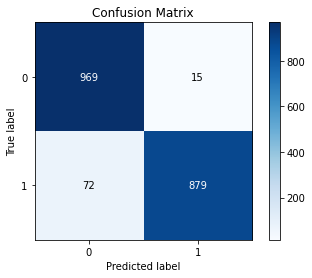

In [16]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
import scikitplot as skplt

lr = LogisticRegression(C=10, max_iter=500, random_state=0)

# Functions used to generate confusion matrix

def PrintStats(cmat, y_test, pred):
    tpos = cmat[0][0]
    fneg = cmat[1][1]
    fpos = cmat[0][1]
    tneg = cmat[1][0]

def RunModel(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train.values.ravel())
    pred = model.predict(X_test)
    matrix = confusion_matrix(y_test, pred)
    return matrix, pred


cmat, pred = RunModel(lr, X_train_scaled, y_train, X_test_scaled, y_test)
print("Accuracy:",metrics.accuracy_score(y_test, pred))
skplt.metrics.plot_confusion_matrix(y_test, pred)

### Pipelines

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

pipeline_lr=Pipeline([('lr_classifier',LogisticRegression(penalty='l2',random_state=0))])
pipeline_dt=Pipeline([('dt_classifier',DecisionTreeClassifier())])
pipeline_randomforest=Pipeline([('rf_classifier',RandomForestClassifier())])


## creating a pipeline including the classifiers defined above
pipelines = [pipeline_lr, pipeline_dt, pipeline_randomforest]

best_accuracy=0.0
best_classifier=0
best_pipeline=""


# Dictionary of pipelines and classifier types for ease of reference
pipe_dict = {0: 'Logistic Regression', 1: 'Decision Tree', 2: 'RandomForest'}

# Fit the pipelines
for pipe in pipelines:
    pipe.fit(X_train_scaled, y_train)
    
for i,model in enumerate(pipelines):
    print("{} Test Accuracy: {}".format(pipe_dict[i],model.score(X_test_scaled,y_test)))

Optimising randomForest's hyperparameters might be worth visiting. Unfortunately, the process crashed shortly after launching it due to a lack of resources.

### Pipeline and Gridsearch

Unfortunately I cannot implement a gridsearch to optimise randomforest's hyperparameters because my laptop does not have enough memory to process the request. Although I do not believe this would increase the accuracy significantly, it might get us above 95%. Sadly I cannot test it :(

In [ ]:
from sklearn.model_selection import GridSearchCV
# Create a pipeline
pipe = Pipeline([("classifier", RandomForestClassifier())])
# Create dictionary with algorithms and their hyperparameters
grid_param = [{"classifier": [RandomForestClassifier()],
                 "classifier__n_estimators": [10, 100, 1000],
                 "classifier__max_depth":[5,8,15],
                 "classifier__min_samples_leaf":[1,2,5,10,15,100],
                 "classifier__max_leaf_nodes": [2, 5,10]}]
# create a gridsearch of the pipeline, the fit the best model
gridsearch = GridSearchCV(pipe, grid_param, verbose=0,n_jobs=-1) 

best_model = gridsearch.fit(X_train_scaled,y_train)

print(best_model.best_estimator_)
print("The mean accuracy of the model is:",best_model.score(X_test_scaled,y_test))